In [19]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import plotly.express as px
import itertools
import plotly.graph_objects as go

from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, roc_auc_score
from sklearn.model_selection import GridSearchCV, cross_validate, train_test_split
from sklearn.preprocessing import LabelEncoder, StandardScaler, RobustScaler
from sklearn.ensemble import RandomForestClassifier, AdaBoostClassifier, GradientBoostingClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.neighbors import KNeighborsClassifier
from sklearn.svm import SVC
from sklearn.impute import KNNImputer
from xgboost import XGBClassifier

In [20]:
df = pd.read_csv('data/diabetes.csv')
df.sample(5)

,Pregnancies,Glucose,BloodPressure,SkinThickness,Insulin,BMI,DiabetesPedigreeFunction,Age,Outcome
680,2,56,56,28,45,24.2,0.332,22,0
100,1,163,72,0,0,39.0,1.222,33,1
357,13,129,0,30,0,39.9,0.569,44,1
490,2,83,65,28,66,36.8,0.629,24,0
544,1,88,78,29,76,32.0,0.365,29,0


In [21]:
def check_df(df):
    '''
    Understand the data
    '''
    print('####Shape####')
    print(df.shape)
    print('\n####Types####')
    print(df.dtypes)
    print('\n####NA####')
    print(df.isnull().sum())
    print('\n####NA####')
    print(df.info())
    print('\n####Quantiles####')
    print(df.describe())

def grab_cols(df, cat_th = 10, car_th = 20):
    cat_cols = [col for col in df.columns if df[col].dtypes=='O']
    num_but_cat = [col for col in df.columns if df[col].dtypes!='O' and df[col].nunique() < cat_th]
    cat_but_car = [col for col in df.columns if df[col].dtypes=='O' and df[col].nunique() > car_th]
    cat_cols = cat_cols + num_but_cat
    cat_cols = [col for col in cat_cols if col not in cat_but_car]

    num_cols = [col for col in df.columns if df[col].dtypes!='O']
    num_cols = [col for col in num_cols if col not in num_but_cat]
    
    return cat_cols, num_cols, cat_but_car, num_but_cat

In [ ]:
check_df(df)

In [22]:
cat_cols, num_cols, cat_but_car, num_but_cat = grab_cols(df)
cat_cols

['Outcome']

In [ ]:
def analyze_num(df, col, plot=False):
    print(df[col].describe([0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9, 0.95, 0.99]))
    if plot:
        df[col].hist(bins=30)
        plt.xlabel(col)
        plt.title(col)
        plt.show()
        
for col in num_cols: 
    analyze_num(df, col, plot=True)

In [ ]:
def target_summ_with_num(df, col, target, plot=False):
    temp = pd.DataFrame(df.groupby(target)[col].mean())
    print(temp)
    if plot:
        sns.barplot(x=df[target], y=df[col])
        plt.show()

for col in num_cols:
    target_summ_with_num(df, col, 'Outcome', plot=True)

In [ ]:
sns.heatmap(df[num_cols].corr(), annot=True, fmt='.2f')

# make pairplots

### feature engineering

In [23]:
# missing values: they are filled with 0 in the dataset(except pregnancies and outcome)

zero_cols = [col for col in df.columns if (df[col].min()==0 and col not in ['Pregnancies','Outcome'])]
zero_cols

['Glucose', 'BloodPressure', 'SkinThickness', 'Insulin', 'BMI']

In [24]:
for col in zero_cols:
    df[col] = np.where(df[col]==0, np.nan, df[col])

In [25]:
df.isnull().sum()

Pregnancies                   0
Glucose                       5
BloodPressure                35
SkinThickness               227
Insulin                     374
BMI                          11
DiabetesPedigreeFunction      0
Age                           0
Outcome                       0
dtype: int64

               num_miss  ratio
Insulin             374  48.70
SkinThickness       227  29.56
BloodPressure        35   4.56
BMI                  11   1.43
Glucose               5   0.65


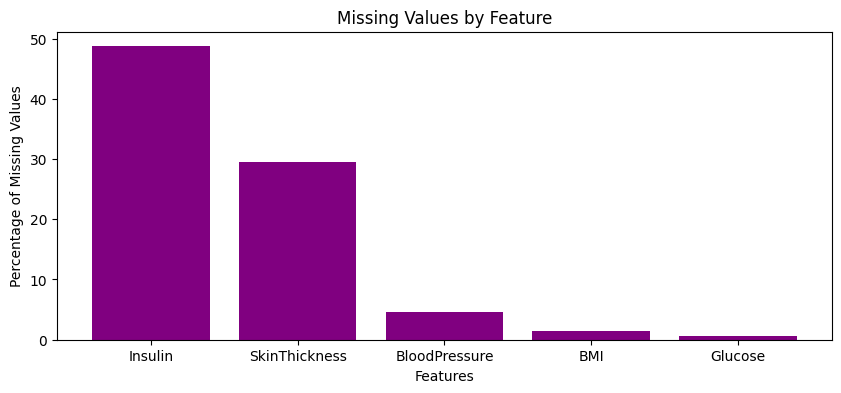

In [26]:
def missing_val_table(df, na_name = False, plot=False):
    na_cols = [col for col in df.columns if df[col].isnull().sum() > 0]
    num_missing = df[na_cols].isnull().sum().sort_values(ascending=False)
    ratio = (df[na_cols].isnull().sum() / df.shape[0] * 100).sort_values(ascending=False)
    df_missing = pd.concat([num_missing, np.round(ratio, 2)], axis=1, keys=['num_miss', 'ratio'])
    print(df_missing)
    
    if plot:
        plt.figure(figsize=(10,4))
        plt.bar(df_missing.index, df_missing['ratio'], color='purple')
        plt.xlabel('Features')
        plt.ylabel('Percentage of Missing Values')
        plt.title('Missing Values by Feature')
        plt.show()
    
    if na_name:
        return na_cols

na_columns = missing_val_table(df, na_name=True, plot=True)

In [27]:
na_columns

['Glucose', 'BloodPressure', 'SkinThickness', 'Insulin', 'BMI']

In [ ]:
def missing_vs_target(df, target, na_columns, plot=False):
    temp_df = df.copy()
    for col in na_columns:
        temp_df[col+'_NA_FLAG'] = np.where(temp_df[col].isnull(), 1, 0)
    na_flags = temp_df.loc[:, temp_df.columns.str.contains('_NA_')].columns
    for col in na_flags:
        print(pd.DataFrame({"TARGET_MEAN": temp_df.groupby(col)[target].mean(),
                            "Count": temp_df.groupby(col)[target].count()}))
        
        if plot:
            plt.figure(figsize=(6, 4))
            temp_df.groupby(col)[target].mean().plot(kind='bar', color='purple')
            plt.xlabel(col)
            plt.ylabel('Target Mean')
            plt.title(f'Target Mean by {col}')
            plt.xticks(rotation=0)
            plt.tight_layout()
            plt.show()
            print("######################################################################")
    
missing_vs_target(df, 'Outcome', na_columns=na_columns, plot=True)

In [28]:
dff = df[na_columns]
dff.head(3)

,Glucose,BloodPressure,SkinThickness,Insulin,BMI
0,148.0,72.0,35.0,NaN,33.6
1,85.0,66.0,29.0,NaN,26.6
2,183.0,64.0,NaN,NaN,23.3


In [29]:
rs = RobustScaler()
dff = pd.DataFrame(rs.fit_transform(dff), columns=dff.columns)

In [30]:
dff.head(3)

,Glucose,BloodPressure,SkinThickness,Insulin,BMI
0,0.738095,0.000,0.428571,NaN,0.142857
1,-0.761905,-0.375,0.000000,NaN,-0.626374
2,1.571429,-0.500,NaN,NaN,-0.989011


In [31]:
dff = pd.DataFrame(KNNImputer(n_neighbors=5).fit_transform(dff), columns=dff.columns)

In [32]:
dff = pd.DataFrame(rs.inverse_transform(dff), columns=dff.columns)
df[na_columns] = dff

In [33]:
# outlier analysis

def outlier_thresholds(df, col, q1=0.05, q3=0.95):
    quartile1 = df[col].quantile(q1)
    quartile3 = df[col].quantile(q3)
    iqr = quartile3 - quartile1
    up_limit = quartile3 + 1.5*iqr
    low_limit = quartile1 - 1.5*iqr
    return (low_limit, up_limit)

def check_outlier(df, col, plot=False):
    low_limit, up_limit = outlier_thresholds(df, col)
    outliers = df[(df[col] > up_limit) | (df[col] < low_limit)]
    if outliers.any(axis=None):
        if plot:
            plt.figure(figsize=(8, 6))
            sns.boxplot(x=df[col])
            plt.title(f'Outliers in {col}')
            plt.show()
        return True
    else:
        return False

def replace_with_thresholds(df, var, q1=0.05, q3=0.95):
    low_limit, up_limit = outlier_thresholds(df, var, q1=0.05, q3=0.95)
    df.loc[(df[var] < low_limit), var] = low_limit
    df.loc[(df[var] > up_limit), var] = up_limit

Pregnancies False
Glucose False
BloodPressure False


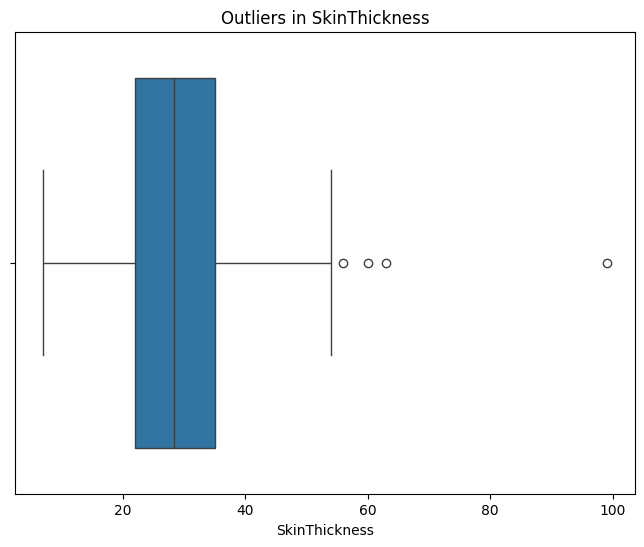

SkinThickness True


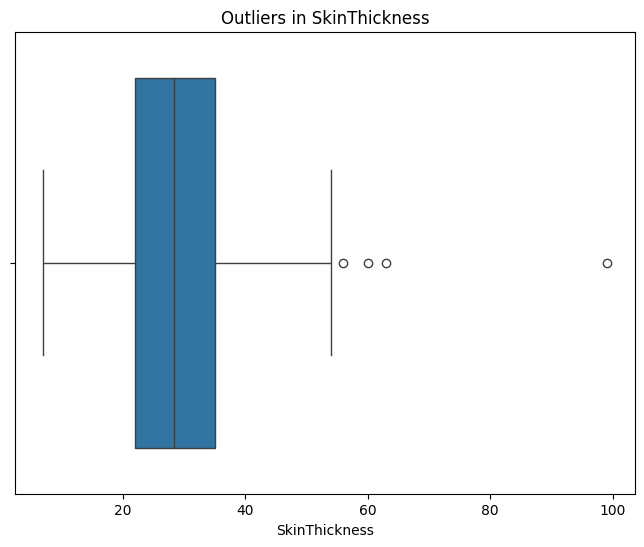

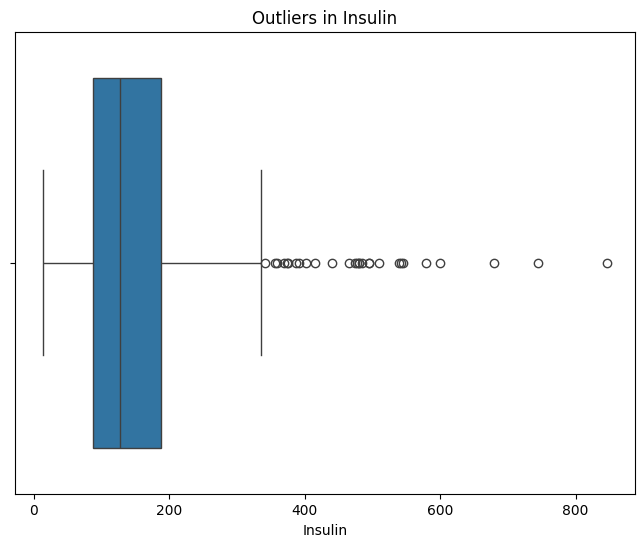

Insulin True


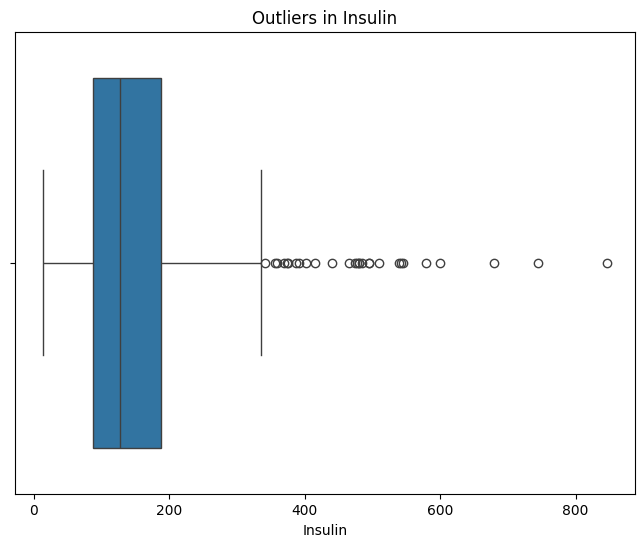

BMI False
DiabetesPedigreeFunction False
Age False
Outcome False


In [34]:
for col in df.columns:
    print(col, check_outlier(df, col, plot=True))
    if check_outlier(df, col, plot=True):
        replace_with_thresholds(df, col)

In [35]:
for col in df.columns:
    print(col, check_outlier(df, col))

Pregnancies False
Glucose False
BloodPressure False
SkinThickness False
Insulin False
BMI False
DiabetesPedigreeFunction False
Age False
Outcome False


In [ ]:
# feature extraction

# df.loc[(df["Age"] >= 21) & (df["Age"] < 50), "NEW_AGE_CAT"] = "mature"
# df.loc[(df["Age"] >= 50), "NEW_AGE_CAT"] = "senior"
# df['NEW_BMI'] = pd.cut(x=df['BMI'], bins=[0, 18.5, 24.9, 29.9, 100],labels=["Underweight", "Healthy", "Overweight", "Obese"])
# df["NEW_GLUCOSE"] = pd.cut(x=df["Glucose"], bins=[0, 140, 200, 300], labels=["Normal", "Prediabetes", "Diabetes"])

In [36]:
df.head(3)

,Pregnancies,Glucose,BloodPressure,SkinThickness,Insulin,BMI,DiabetesPedigreeFunction,Age,Outcome
0,6,148.0,72.0,35.0,196.0,33.6,0.627,50,1
1,1,85.0,66.0,29.0,73.6,26.6,0.351,31,0
2,8,183.0,64.0,25.6,218.2,23.3,0.672,32,1


In [ ]:
# Creating a categorical variable by considering age and body mass index together 3 breakdowns were captured

# df.loc[(df["BMI"] < 18.5) & ((df["Age"] >= 21) & (df["Age"] < 50)), "NEW_AGE_BMI_NOM"] = "underweightmature"
# df.loc[(df["BMI"] < 18.5) & (df["Age"] >= 50), "NEW_AGE_BMI_NOM"] = "underweightsenior"
# df.loc[((df["BMI"] >= 18.5) & (df["BMI"] < 25)) & ((df["Age"] >= 21) & (df["Age"] < 50)), "NEW_AGE_BMI_NOM"] = "healthymature"
# df.loc[((df["BMI"] >= 18.5) & (df["BMI"] < 25)) & (df["Age"] >= 50), "NEW_AGE_BMI_NOM"] = "healthysenior"
# df.loc[((df["BMI"] >= 25) & (df["BMI"] < 30)) & ((df["Age"] >= 21) & (df["Age"] < 50)), "NEW_AGE_BMI_NOM"] = "overweightmature"
# df.loc[((df["BMI"] >= 25) & (df["BMI"] < 30)) & (df["Age"] >= 50), "NEW_AGE_BMI_NOM"] = "overweightsenior"
# df.loc[(df["BMI"] > 18.5) & ((df["Age"] >= 21) & (df["Age"] < 50)), "NEW_AGE_BMI_NOM"] = "obesemature"
# df.loc[(df["BMI"] > 18.5) & (df["Age"] >= 50), "NEW_AGE_BMI_NOM"] = "obesesenior"

In [ ]:
# Creating a categorical variable by considering age and glucose values together

# df.loc[(df["Glucose"] < 70) & ((df["Age"] >= 21) & (df["Age"] < 50)), "NEW_AGE_GLUCOSE_NOM"] = "lowmature"
# df.loc[(df["Glucose"] < 70) & (df["Age"] >= 50), "NEW_AGE_GLUCOSE_NOM"] = "lowsenior"
# df.loc[((df["Glucose"] >= 70) & (df["Glucose"] < 100)) & ((df["Age"] >= 21) & (df["Age"] < 50)), "NEW_AGE_GLUCOSE_NOM"] = "normalmature"
# df.loc[((df["Glucose"] >= 70) & (df["Glucose"] < 100)) & (df["Age"] >= 50), "NEW_AGE_GLUCOSE_NOM"] = "normalsenior"
# df.loc[((df["Glucose"] >= 100) & (df["Glucose"] <= 125)) & ((df["Age"] >= 21) & (df["Age"] < 50)), "NEW_AGE_GLUCOSE_NOM"] = "hiddenmature"
# df.loc[((df["Glucose"] >= 100) & (df["Glucose"] <= 125)) & (df["Age"] >= 50), "NEW_AGE_GLUCOSE_NOM"] = "hiddensenior"
# df.loc[(df["Glucose"] > 125) & ((df["Age"] >= 21) & (df["Age"] < 50)), "NEW_AGE_GLUCOSE_NOM"] = "highmature"
# df.loc[(df["Glucose"] > 125) & (df["Age"] >= 50), "NEW_AGE_GLUCOSE_NOM"] = "highsenior"

In [ ]:
# Deriving a Categorical variable with Insulin Value.

# def set_insulin(df, col="Insulin"):
#     if 16 <= df[col] <= 166:
#         return
#     else:
#         return "Abnormal"

# df['NEW_INSULIN_SCORE'] = df.apply(set_insulin, axis=1)
# df['NEW_GLUCOSE * INSULIN'] = df['Glucose'] * df['Insulin']

In [ ]:
# Attention to values with zero !!!

# df["NEW_GLUCOSE * PREGNANCIES"] = df["Glucose"] * df["Pregnancies"]

In [ ]:
df.columns = [col.upper() for col in df.columns]
cat_cols, num_cols, cat_but_car, num_but_cat = grab_cols(df)

In [39]:
num_but_cat

['OUTCOME']

In [40]:
# label encoding

def label_encoder(df, col):
    le = LabelEncoder()
    df[col] = le.fit_transform(df[col])
    return df

binary_cols = [col for col in df.columns if df[col].dtypes=='O' and df[col].nunique()==2]
binary_cols

[]

In [ ]:
# df = label_encoder(df, 'NEW_AGE_CAT')

In [41]:
df.head(5)

,PREGNANCIES,GLUCOSE,BLOODPRESSURE,SKINTHICKNESS,INSULIN,BMI,DIABETESPEDIGREEFUNCTION,AGE,OUTCOME
0,6,148.0,72.0,35.0,196.0,33.6,0.627,50,1
1,1,85.0,66.0,29.0,73.6,26.6,0.351,31,0
2,8,183.0,64.0,25.6,218.2,23.3,0.672,32,1
3,1,89.0,66.0,23.0,94.0,28.1,0.167,21,0
4,0,137.0,40.0,35.0,168.0,43.1,2.288,33,1


In [42]:
cat_cols = [col for col in cat_cols if col not in binary_cols and col not in ["OUTCOME"]]
cat_cols

[]

In [43]:
def ohe(df, cols, drop_first=False):
    df = pd.get_dummies(df, columns=cols, drop_first = drop_first)
    return df

df = ohe(df, cat_cols, drop_first = True)

In [44]:
scaler = RobustScaler()
df[num_cols] = scaler.fit_transform(df[num_cols])

In [45]:
# model building
y = df['OUTCOME']
X = df.drop('OUTCOME', axis=1)
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.30, random_state=42)

In [46]:
svc_model = SVC(random_state=46)
parameters = {'C': [0.1, 1, 10],
              'kernel': ['linear', 'rbf']}
svc_grid = GridSearchCV(svc_model, parameters, cv=5).fit(X_train, y_train)

best_svc_model = svc_grid.best_estimator_

print("Support Vector Classifier (SVC) - Hyperparameter Optimization")
print(f"Best Parameters: {svc_grid.best_params_}")
print(f"Accuracy: {round(svc_grid.best_score_, 4)}")
print(f"Recall: {round(recall_score(best_svc_model.predict(X_test), y_test), 4)}")
print(f"Precision: {round(precision_score(best_svc_model.predict(X_test), y_test), 4)}")
print(f"F1: {round(f1_score(best_svc_model.predict(X_test), y_test), 4)}")
print(f"AUC: {round(roc_auc_score(best_svc_model.predict(X_test), y_test), 4)}")

Support Vector Classifier (SVC) - Hyperparameter Optimization
Best Parameters: {'C': 10, 'kernel': 'linear'}
Accuracy: 0.7802
Recall: 0.6447
Precision: 0.6125
F1: 0.6282
AUC: 0.7224


In [47]:
import joblib

joblib.dump(best_svc_model, 'my_model.pkl')

['my_model.pkl']